# Climate Coding Challenge

Climate change is impacting the way people live around the world

# Plot your results

## STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [1]:
%store -r

In [2]:
import matplotlib.pyplot as plt
import holoviews as hv
import hvplot.pandas  # adds .hvplot to DataFrames/Series
hv.extension('bokeh')  # important!
import pandas as pd

In [3]:
## I noticed the some of the data is bad. I read about the flags, and want to use only the acceptable data:
# Keep only '...' flagged data
# Keep only rows where qcflag is exactly '...'
q = co2_df["qcflag"].fillna("").astype(str).str.pad(3, fillchar=".")
mask_qc = (q.str[0] == ".") & (q.str[1] == ".")
co2_df = co2_df.loc[mask_qc].copy()



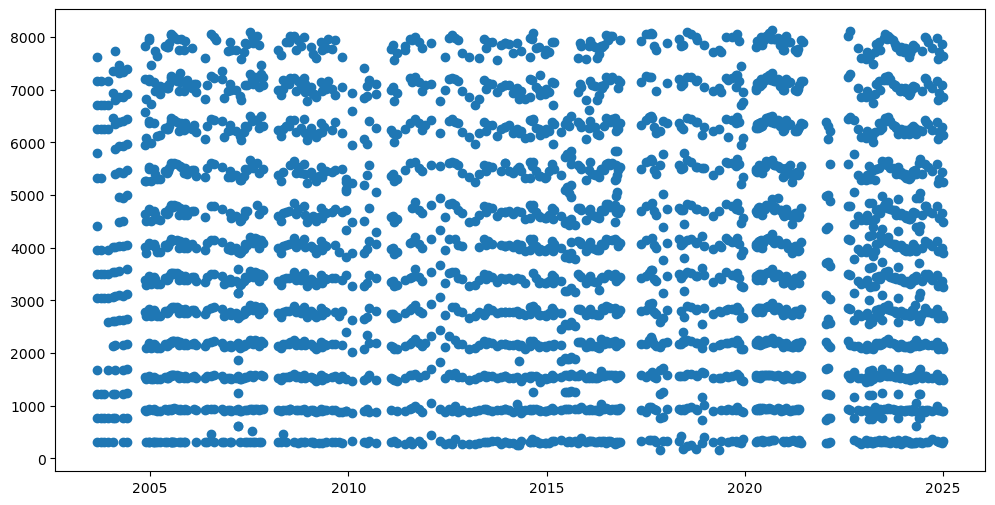

In [4]:

#  Altitude (meters) over time
plt.figure(figsize=(12, 6))
plt.scatter(co2_df["time_decimal"], co2_df["altitude"])
plt.show()

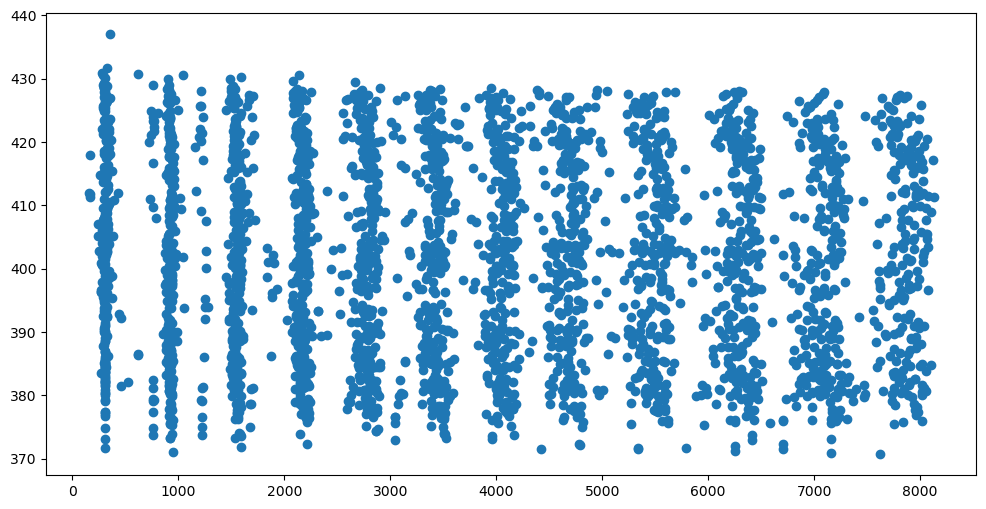

In [5]:
#  Altitude (meters) over time
plt.figure(figsize=(12, 6))
plt.scatter(co2_df["altitude"], co2_df["value"])
plt.show()

In [6]:
co2_df.hvplot.scatter(
    x='altitude', y='value',
    title='CO₂ vs Altitude',
    tools=['pan', 'wheel_zoom', 'box_zoom', 'reset', 'hover'],
    responsive=True, height=450,
    size=5, alpha=0.6
)

:Scatter   [altitude]   (value)

In [7]:
print(co2_df['value'].min(), co2_df['value'].max())


370.7 437.03


In [8]:

co2_df.hvplot.scatter(
    x='time_decimal', y='altitude',
    color='value',                 # <— use 'color' explicitly
    cmap='viridis',
    clim=(287.06, 450),            # lock color scale
    clabel='CO₂ (ppm)',            # colorbar label
    colorbar=True,
    tools=['pan','wheel_zoom','box_zoom','reset','hover'],
    responsive=True, height=500, width=900,
    size=8, alpha=0.7
)


:Scatter   [time_decimal]   (altitude,value)

In [9]:
subset = co2_df[(co2_df["altitude"] >= 7000) & (co2_df["altitude"] <= 9000)]

subset.hvplot.scatter(
    x='time_decimal', y='altitude',
    c='value',
    cmap='viridis',
    clim=(370, 500),         # fixed color scale
    colorbar=True,
    title='Altitude 7000–9000 m (colored by CO₂)',
    tools=['pan', 'wheel_zoom', 'box_zoom', 'reset', 'hover'],
    responsive=True, height=500, width=900,
    size=8, alpha=0.7
)


:Scatter   [time_decimal]   (altitude,value)

In [10]:


# CO₂ vs time
subset.hvplot.scatter(
    x='time_decimal', y='value',
    cmap='viridis',
    clim=(370, 500),
    colorbar=True,
    title='CO₂ vs Time (7000–9000 m)',
    tools=['pan', 'wheel_zoom', 'box_zoom', 'reset', 'hover'],
    responsive=True, height=500, width=900,
    size=8, alpha=0.7
)


:Scatter   [time_decimal]   (value)

In [11]:
# --- Define profile by calendar day (UTC) ---
co2_df["profile_date"] = pd.to_datetime(
    dict(year=co2_df["year"].astype(int),
         month=co2_df["month"].astype(int),
         day=co2_df["day"].astype(int)),
    errors="coerce", utc=True
)

# --- Highest-altitude sample per profile day ---
idx_top = co2_df.groupby("profile_date")["altitude"].idxmax()

profile_tops = (
    co2_df.loc[idx_top, ["profile_date", "time_decimal", "altitude", "value"]]
           .rename(columns={"value": "co2_ppm"})
           .sort_values("profile_date")
           .reset_index(drop=True)
)

print(profile_tops)

                 profile_date  time_decimal  altitude  co2_ppm
0   2003-09-02 00:00:00+00:00   2003.671123   7620.00   370.70
1   2003-10-08 00:00:00+00:00   2003.769054   7162.80   373.18
2   2003-11-05 00:00:00+00:00   2003.845915   6705.60   376.16
3   2003-12-08 00:00:00+00:00   2003.936553   7162.80   375.61
4   2004-01-22 00:00:00+00:00   2004.059255   7367.07   379.11
..                        ...           ...       ...      ...
294 2024-11-06 00:00:00+00:00   2024.849313   7986.98   423.64
295 2024-11-15 00:00:00+00:00   2024.874089   7577.02   423.42
296 2024-11-27 00:00:00+00:00   2024.906729   7714.18   425.37
297 2024-12-17 00:00:00+00:00   2024.961506   7874.81   427.28
298 2024-12-30 00:00:00+00:00   2024.997041   7643.47   426.96

[299 rows x 4 columns]


In [12]:
scatter = profile_tops.hvplot.scatter(
    x='time_decimal', y='co2_ppm',
    cmap='viridis',
    clim=(370, 500),
    colorbar=True,
    title='Top-of-profile CO₂ vs Time',
    tools=['pan', 'wheel_zoom', 'box_zoom', 'reset', 'hover'],
    responsive=True, height=500, width=900,
    size=8, alpha=0.7,
    hover_cols=['profile_date', 'altitude']
)
scatter


:Scatter   [time_decimal]   (co2_ppm,profile_date,altitude)

In [13]:
import numpy as np
# --- scatter (bigger points + axis labels) ---
scatter = profile_tops.hvplot.scatter(
    x='time_decimal', y='co2_ppm',
    cmap='viridis',
    clim=(370, 500),
    colorbar=True,
    title='Top-of-profile CO₂ vs Time',
    tools=['pan', 'wheel_zoom', 'box_zoom', 'reset', 'hover'],
    width=900, height=500,                # explicit size plays nice with some envs
    size=12, alpha=0.8,                   # bigger points
    hover_cols=['profile_date', 'altitude'],
    xlabel='Time (years)',                # <- axis labels
    ylabel='CO₂ (ppm)'
)

# --- simple linear trend line (least squares) ---
x = profile_tops["time_decimal"].to_numpy()
y = profile_tops["co2_ppm"].to_numpy()
m, b = np.polyfit(x, y, 1)               # y = m*x + b  (ppm per year)

# make a tidy df for the fitted line across the domain
x_fit = np.linspace(np.nanmin(x), np.nanmax(x), 200)
trend_df = pd.DataFrame({"time_decimal": x_fit, "co2_fit": m*x_fit + b})

trend = trend_df.hvplot.line(
    x='time_decimal', y='co2_fit',
    line_width=2, line_dash='dashed',
    label=f'Linear trend (~{m:.2f} ppm/yr)'
)

# overlay
scatter * trend

:Overlay
   .Scatter.I                                                                              :Scatter   [time_decimal]   (co2_ppm,profile_date,altitude)
   .Curve.Linear_trend_left_parenthesis_tilde_2_full_stop_36_ppm_over_yr_right_parenthesis :Curve   [time_decimal]   (co2_fit)

In [14]:
# --- Scatter (bigger points, axis labels, add label for legend) ---
scatter = profile_tops.hvplot.scatter(
    x='time_decimal', y='co2_ppm',
    width=900, height=500,
    size=20, alpha=0.8,
    xlabel='Time (years)',
    ylabel='CO₂ (ppm)',
    tools=['pan', 'wheel_zoom', 'box_zoom', 'reset', 'hover'],
    hover_cols=['profile_date', 'altitude'],
    color='#2c7fb8',              # distinct point color (blue-ish)
    label='CO₂ at top of profile'
)

# --- Exponential fit: y = a * exp(b*x) (do linear fit on log(y)) ---
x = profile_tops["time_decimal"].to_numpy()
y = profile_tops["co2_ppm"].to_numpy()

mask = np.isfinite(x) & np.isfinite(y) & (y > 0)
x_fit_data = x[mask]
y_fit_data = y[mask]

B, lnA = np.polyfit(x_fit_data, np.log(y_fit_data), 1)  # ln(y) = lnA + B*x
A = np.exp(lnA)

x_line = np.linspace(x_fit_data.min(), x_fit_data.max(), 300)
y_line = A * np.exp(B * x_line)
trend_df = pd.DataFrame({'time_decimal': x_line, 'co2_exp': y_line})

# Annual percent growth (approx)
pct_per_year = (np.exp(B) - 1) * 100

trend = trend_df.hvplot.line(
    x='time_decimal', y='co2_exp',
    line_width=3,
    color='#d7301f',             # different color (red-ish)
    line_dash='dashed',
    label=f'Exponential trend (~{pct_per_year:.2f}%/yr)'
)

# Show legend
(scatter * trend).opts(legend_position='top_left', show_legend=True)

:Overlay
   .Scatter.CO_subscript_two_at_top_of_profile                                                      :Scatter   [time_decimal]   (co2_ppm,profile_date,altitude)
   .Curve.Exponential_trend_left_parenthesis_tilde_0_full_stop_59_percent_over_yr_right_parenthesis :Curve   [time_decimal]   (co2_exp)

In [17]:
from bokeh.resources import CDN

plot = scatter * trend
hv.save(plot, 'top_profile_co2.html', backend='bokeh', resources=CDN)

